MNSIT problem here is solved using tensor flow API's for convulutional network. 2 hidden and 2 fully connected layers have been used with relu as activation function, cross entropy as loss function, softmax at the last fully connected layer. We have applied batch norm after each conv layer and before applying activation function. Batch norm is not done only in last fully connected layer and instead we have applied dropout in the last fully connected layer before doing convolution in that layer. 

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [26]:
images = pd.read_csv('train.csv')

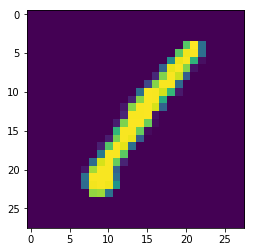

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images.iloc[0][1:].values.reshape([28,28]))

In [ ]:
CLASS_SIZE = 10
starter_learning_rate = 0.01
batch_size = 100

In [28]:
X = images[images.columns[1:]].as_matrix()
Y = np.zeros([len(images),CLASS_SIZE])
for i in range(len(images)):
    Y[i][images.iloc[i]['label']] = 1

In [29]:
inputImageSize = len(images.columns)-1

784

In [30]:
x_ = tf.placeholder(tf.float32,shape=[None,inputImageSize])
y_ = tf.placeholder(tf.float32,shape=[None,CLASS_SIZE])
tst = tf.placeholder(tf.bool)
#iter = tf.placeholder(tf.int32)

In [31]:
def weight_initialise(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)
    

In [32]:
def bias_initialise(shape):
    initial = tf.constant(value=0.1,shape=shape)
    return tf.Variable(initial)

In [ ]:
#conv2d(
#    batch = Size of the subset of examples to use when performing gradient descent during training.
#    input [batch, in_height, in_width, in_channels],
#    filter, [ filter_height, filter_width, in_channels, out_channels]
#    strides, [batch, height, width, channels] here batch = channels = 1 for strides why ? because we cannot skip over any example input as well we cannot skip over any input along any depth 
#                                            but the input along height and column can be skipped .
#                                            so height and width need not be 1  
#    padding,
#    use_cudnn_on_gpu=None,
#    data_format=None,
#    name=None
#)
def conv2d(x,W):   ##Stride of size  [batch, channels, height, width] = [1,1,1,1] and padding = 'SAME' is used 
    return tf.nn.conv2d(x,W,[1,1,1,1],padding='SAME')

#max_pool(
#    value,
#    ksize --  The size of the window for each dimension of the input tensor.
#    strides,
#    padding,
#    data_format='NHWC',
#    name=None
#)
#max pool of 2 x 2 
def max_pool(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [34]:
def batchnorm(Ylogits,shape,is_test=1, convolutional=True):
    offset = tf.Variable(tf.constant(value=0.1,shape=shape))
    ##create an exponential Moving average object with decay  = 0.999 generally close to 0 like 0.9,0.99, 0.999
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    ## for convolutional layer,apply the mean or variance along all three axis - height, width, depth
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    ## for fully connected layer, since the data is all flattened out, calculate mean/variance only along 1 aixs
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    ##create shadow variable for mean and variance , initialise them to their original values, add them to the list of GraphKeys.MOVING_AVERAGE_VARIABLES and return the op which will handle updating moving averages of shadow variables using the formula
    ## shadow variable = decay * shadow _variable + (1-decay) * x
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    ## .average returns the variable holding the moving average of mean/variance variable
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn,update_moving_everages

In [35]:
W_conv1 = weight_initialise([5,5,1,32])  ## Filter of shape [filter_height, filter_width, in_channels, out_channels]
bias1 = bias_initialise([32])

In [36]:
x_image = tf.reshape(x_,shape=[-1,28,28,1])

In [37]:
Conv1 = tf.add(conv2d(x_image,W_conv1),bias1)
Bn1,update_ema1 = batchnorm(Conv1,[32],tst,convolutional=True)
h_conv1 = tf.nn.relu(Bn1)
max_pool1 = max_pool(h_conv1)

In [38]:
#2nd conv layer
W_conv2 = weight_initialise([5,5,32,64])
bias2 = bias_initialise([64])
Conv2 = tf.add(conv2d(max_pool1,W_conv2),bias2)
Bn2,update_ema2 = batchnorm(Conv2,[64],tst,convolutional=True)
h_conv2 = tf.nn.relu(Bn2)
max_pool2 = max_pool(h_conv2)


In [39]:
#fully connected layer
W_fc1 = weight_initialise([7*7*64,1024])
bias_fc1 = bias_initialise([1024])

In [40]:
h_maxpool2_flat = tf.reshape(max_pool2,shape=[-1,7*7*64])
fc1 = tf.matmul(h_maxpool2_flat,W_fc1)+bias_fc1
BnFC1,update_emaFC1 = batchnorm(fc1,[1024],tst,convolutional=False)
h_fc1 = tf.nn.relu(BnFC1)

In [41]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_dropout = tf.nn.dropout(h_fc1,keep_prob=keep_prob)

In [42]:
W_fc2 = weight_initialise([1024,CLASS_SIZE])
bias_fc2 = bias_initialise([CLASS_SIZE])
y_conv = tf.matmul(h_fc1_dropout,W_fc2) + bias_fc2

In [43]:
# variable learning rate
lr = tf.placeholder(tf.float32)

global_step = tf.Variable(0, trainable=False)

total_batch = int(len(X)/batch_size)
####
#exponential_decay(
#    learning_rate,  -- initial learning rate
#    global_step,   -- current step . this will be incremented during gradient descent 
#    decay_steps,    -- perform decay after this many steps
#    decay_rate,     
#    staircase=False,  if staircase is true, then update is performed at every integer division of global_step / decay_steps
#    name=None
#)
##decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, total_batch, 0.96, staircase=True)

In [44]:
##group all the operations which will be executed for update_ema to finish.This is just as a convience not to write all
#these operations sepeartely during update and instead use an alias for them
update_ema = tf.group(update_ema1, update_ema2, update_emaFC1)

In [45]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
## Passing global_step to minimize() will increment it at each step
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step) 

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
for i in range(200):
    avg_cost = 0.0
    # learning rate decay
    for bid in range(total_batch):
        batch_x = X[bid*batch_size:(bid+1)*batch_size]
        batch_y = Y[bid*batch_size:(bid+1)*batch_size]
        _,ct, _ = session.run([train_step,cross_entropy, update_ema],feed_dict={x_: batch_x, y_: batch_y, keep_prob: 0.2,tst:False})
        avg_cost += ct / total_batch
    print('step %d, training accuracy %g' % (i, ct))
        


step 0, training accuracy 0.141816
step 1, training accuracy 0.0669032
step 2, training accuracy 0.0219872
step 3, training accuracy 0.108595
step 4, training accuracy 0.0560566
step 5, training accuracy 0.00869309
step 6, training accuracy 0.0126883
step 7, training accuracy 0.00039305
step 8, training accuracy 0.00141179
step 9, training accuracy 0.00281328
step 10, training accuracy 0.0479677
step 11, training accuracy 0.00362573
step 12, training accuracy 0.00427259
step 13, training accuracy 0.000249512
step 14, training accuracy 0.000792261
step 15, training accuracy 0.00552118
step 16, training accuracy 0.00061695
step 17, training accuracy 0.0277134
step 18, training accuracy 0.000712784
step 19, training accuracy 0.0139196
step 20, training accuracy 0.00688288
step 21, training accuracy 0.0113886
step 22, training accuracy 0.0409015
step 23, training accuracy 0.0073741
step 24, training accuracy 0.000215316
step 25, training accuracy 0.0251535
step 26, training accuracy 0.0002

In [46]:
test_data = pd.read_csv("test.csv")
Xtest = test_data.as_matrix()

In [47]:
test_pred = session.run(y_conv,feed_dict={x_:Xtest,keep_prob:1.0,tst:True})
outValue = session.run(tf.arg_max(test_pred,1))

In [48]:
output = pd.DataFrame(outValue, columns=["Label"],index=range(1,28001))
output.index.names = ['ImageId']
output.to_csv('outputConvNetlong.csv')